In [3]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))
import spatial_metrics.helper_functions as hf
import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_base as pl
import spatial_metrics.detect_peaks as dp



In [35]:

srate = 100. # points/frames per second
total_Time = 1000 # in seconds
_lambda = 10 # how much your neuron should spike
environment_edges = [[0,100],[0,100]] # in cm [[x1,x2],[y1,y2]]

x_coordinates,y_coordinates,speed,timevector = cs_model.generate_random_walk(input_srate = srate,input_total_Time = total_Time,heading_srate = 10., speed_srate = 5., rho1  = 1,sigma = 0.02,mu_e  = 0.,smooth_coeff = 0.5,environment_edges = environment_edges)
total_points = timevector.shape[0]


timestamps = cs_model.generate_arrivals(_lambda,total_Time)
I_timestamps = (timestamps*srate).astype(int)

# place cell with one field: x_center and y_center is the location of the place field in ehe environment; s is the field variance
modulated_timestamps = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 35,y_center = 25, s = 20)

# grid cell with several fields
# modulated_timestamps1 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 50,y_center = 50, s = 5)
# modulated_timestamps2 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 10, s = 5)
# modulated_timestamps3 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 10,y_center = 90, s = 5)
# modulated_timestamps4 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 90, s = 5)
# modulated_timestamps5 = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,I_timestamps,x_center = 90,y_center = 10, s = 5)
# modulated_timestamps = np.unique(np.concatenate([modulated_timestamps1,modulated_timestamps2,modulated_timestamps3,modulated_timestamps4,modulated_timestamps5]))

# if you want to control for the amount of spikes, set a fixed value for spikes
# num_of_spikes = 50
# modulated_timestamps = np.sort(np.random.choice(modulated_timestamps,num_of_spikes,replace=False))

calcium_imag,timevector = cs_model.generate_calcium_signal(modulated_timestamps,total_points,srate,noise_level = 0.01, b = 5.)
calcium_events = modulated_timestamps.shape[0]
I_peaks = dp.detect_peaks(calcium_imag,mpd=0.5*srate,mph=1.*np.nanstd(calcium_imag))



In [36]:
z_threshold = 2
srate = 100

#filtered_signal = hf.eegfilt(calcium_imag,srate,0,2/(srate/2),order=2)
filtered_signal = hf.eegfilt(calcium_imag,srate,0,2,order=2)
norm_signal = filtered_signal/np.std(filtered_signal)

diff_signal = np.hstack([np.diff(filtered_signal),0])
binarized_signal = np.zeros(calcium_imag.shape[0])
binarized_signal[(norm_signal>z_threshold) & (diff_signal>0)] = 1

diff_signal_truncated = np.copy(diff_signal)
diff_signal_truncated[diff_signal<0] = 0

In [37]:



input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Binarized'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shuffling_shift'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 12
input_dict['saving_path'] = None
input_dict['saving'] = False

place_cell = pl.PlaceCellBinarized(**input_dict)

place_cell_output = place_cell.main(binarized_signal,timevector,x_coordinates,y_coordinates)


File not saved!


In [47]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
srate = 1/np.nanmean(np.diff(timevector))

input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate 
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shuffling_shift'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 12
input_dict['saving_path'] = None
input_dict['saving'] = False

        
place_cell = pl.PlaceCell(**input_dict)

place_cell_output = place_cell.main(calcium_imag,timevector,x_coordinates,y_coordinates)



File not saved!


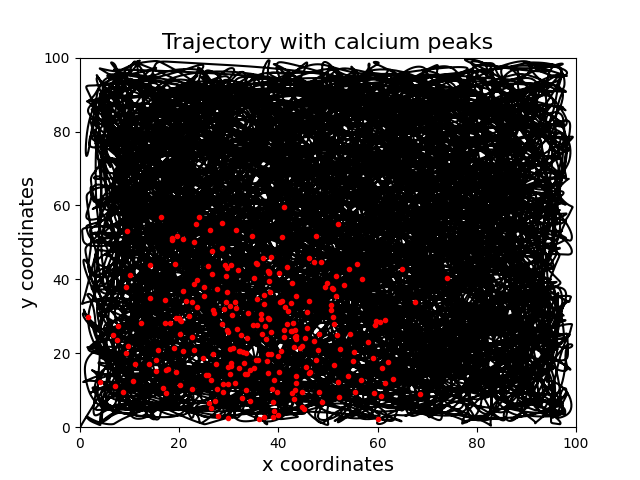

In [38]:
events_index = place_cell_output['events_index']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=1)
plt.plot(x_coordinates[events_index],y_coordinates[events_index],'r.')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


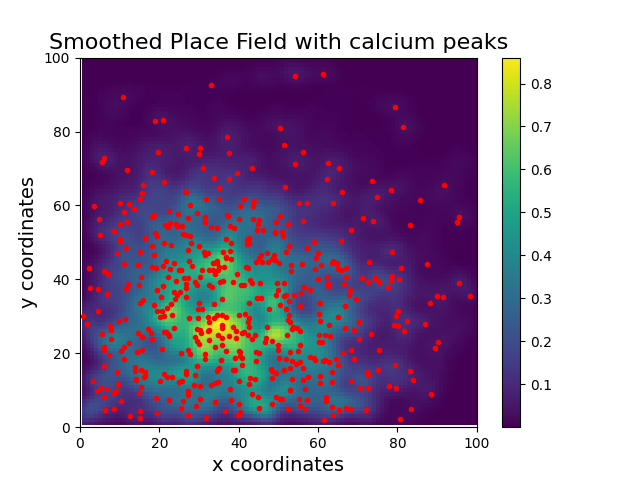

In [44]:
events_index = place_cell_output['events_index']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.plot(x_coordinates[events_index],y_coordinates[events_index],'r.')
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


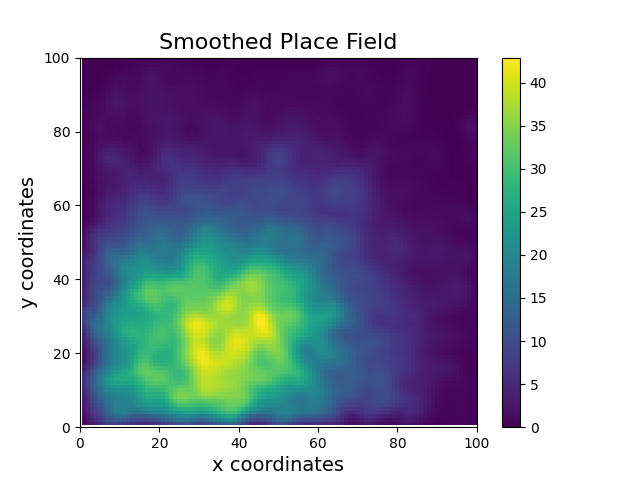

In [48]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.title('Smoothed Place Field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


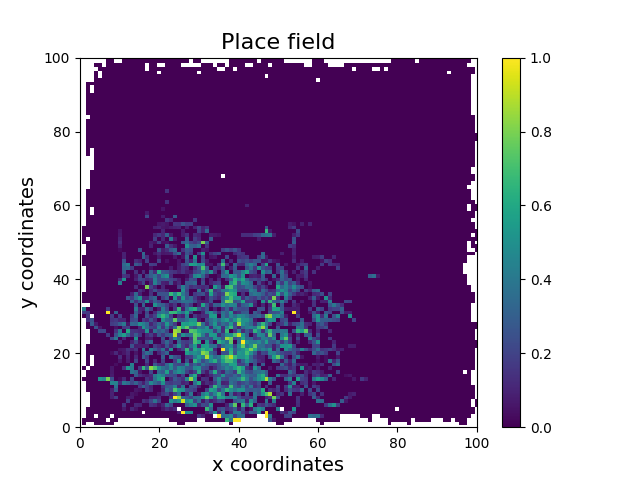

In [41]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'])
plt.colorbar()
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


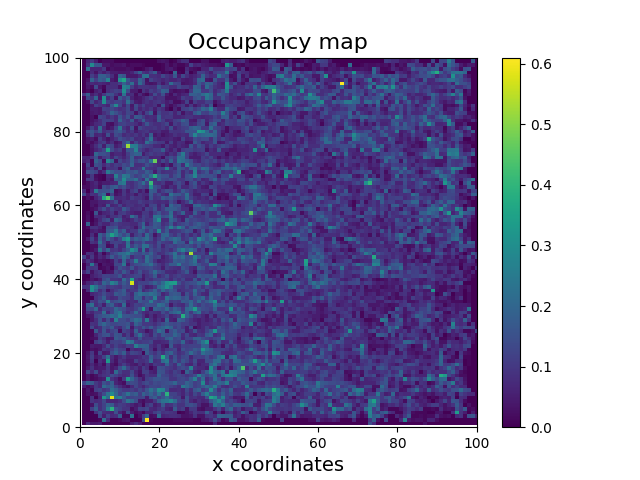

In [18]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


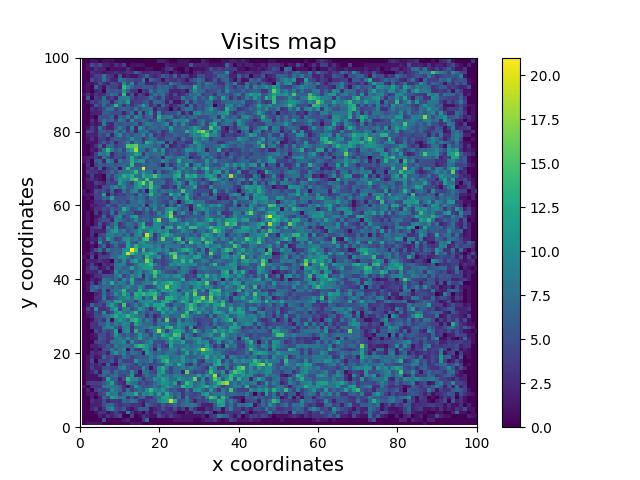

In [11]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


0.005

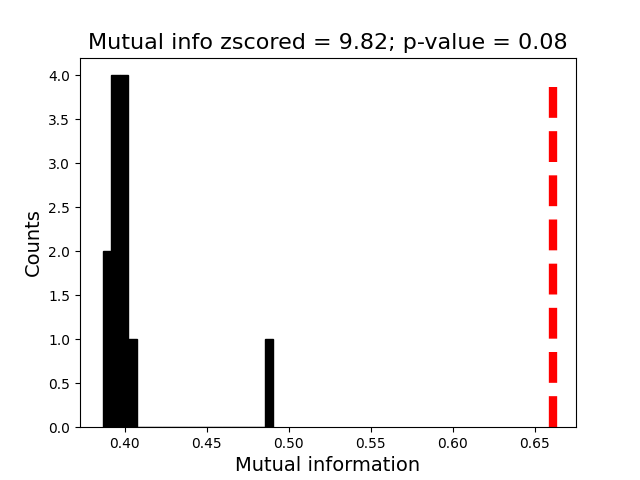

In [49]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.show()


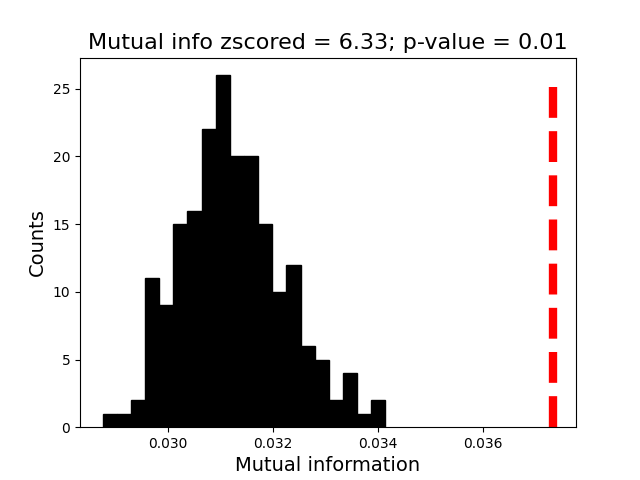

In [19]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shuffled'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.show()


In [15]:
# Surrogate procedure demonstration - take the signal above, shuffle it and check if it is significant (it shouldn't)

# https://www.sciencedirect.com/science/article/pii/S0370157318301340


input_dict = dict()
input_dict['saving_string'] = 'SpatialMetrics.Shifted'
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['mean_video_srate'] = srate
input_dict['mintimespent'] = 0
input_dict['minvisits'] = 0
input_dict['speed_threshold'] = 0 
input_dict['x_bin_size'] = 1 # y bin size in cm
input_dict['y_bin_size'] = 1 # y bin size in cm
input_dict['environment_edges'] = environment_edges # in cm
input_dict['shuffling_shift'] = 100
input_dict['num_cores'] = 20
input_dict['num_surrogates'] = 12
input_dict['saving_path'] = None
input_dict['saving'] = False

place_cell_shuff = pl.PlaceCell(**input_dict)

calcium_imag_shuffled = place_cell_shuff.get_surrogate(calcium_imag,shuffling_shift=200,mean_video_srate = srate)

place_cell_output_shuff = place_cell_shuff.main(calcium_imag_shuffled,timevector,x_coordinates,y_coordinates)


File not saved!


In [90]:
place_cell_output_shuff.keys()

dict_keys(['signal_map', 'place_field', 'place_field_smoothed', 'ocuppancy_map', 'visits_map', 'x_grid', 'y_grid', 'x_center_bins', 'y_center_bins', 'numb_events', 'events_index', 'mutual_info_original', 'mutual_info_shuffled', 'mutual_info_zscored', 'mutual_info_centered', 'num_of_islands', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'input_parameters'])

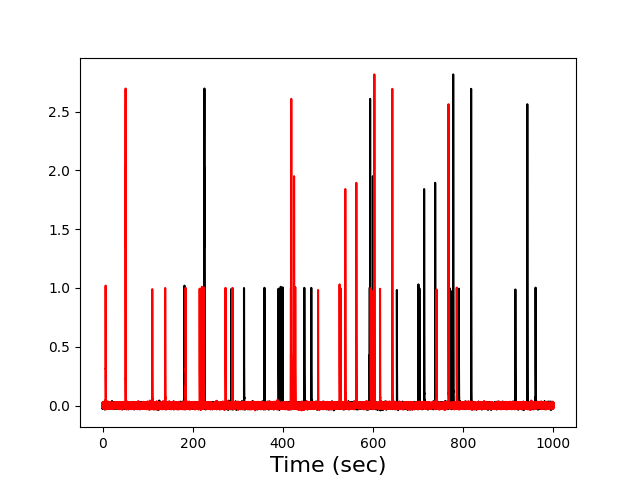

In [17]:

plt.figure()
plt.plot(timevector,calcium_imag,'k')
plt.plot(timevector,calcium_imag_shuffled,'r')
plt.xlabel('Time (sec)', fontsize=16)
plt.show()

# os.chdir(path + '/figures/')
# plt.savefig('Surrogate_Trace_Example{0}.svg'.format(surr))


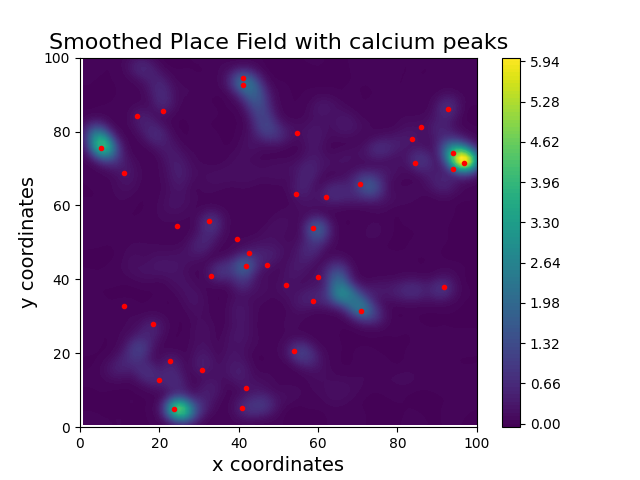

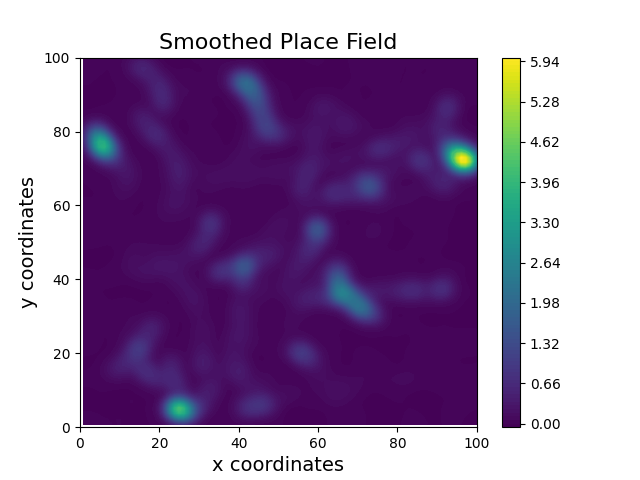

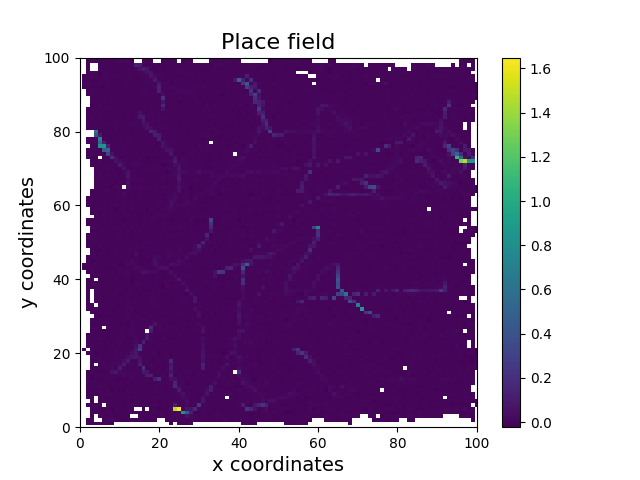

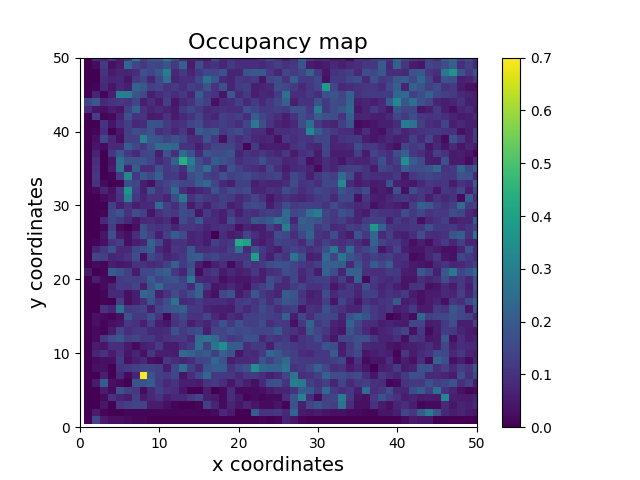

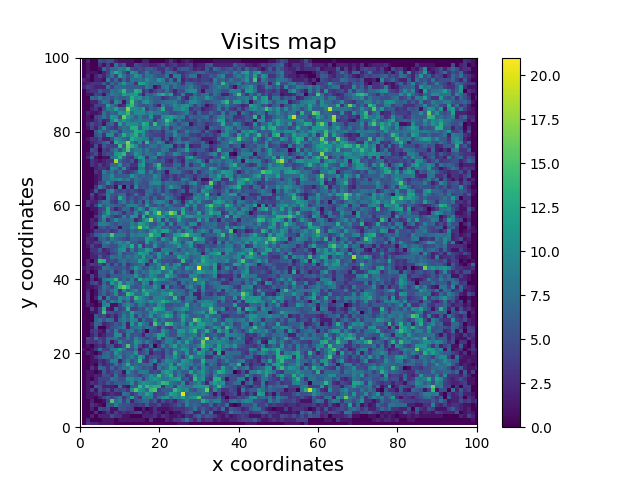

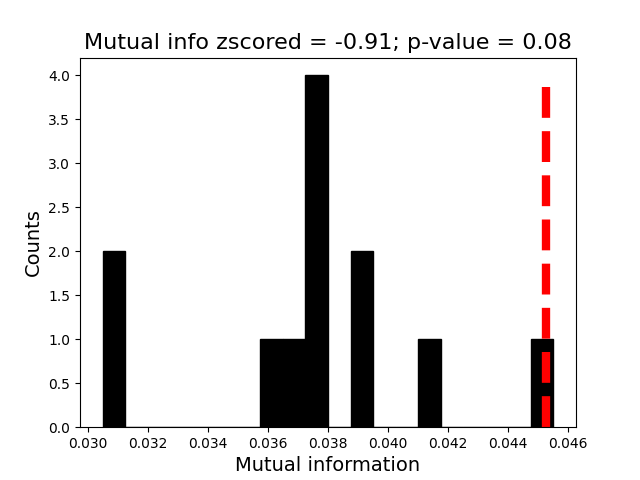

In [18]:


events_index = place_cell_output_shuff['events_index']

plt.figure()
cnt = plt.contourf(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'],100)
for c in cnt.collections:
    c.set_edgecolor("face")

plt.plot(x_coordinates[events_index],y_coordinates[events_index],'r.')
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


plt.figure()
cnt = plt.contourf(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field_smoothed'],100)
for c in cnt.collections:
    c.set_edgecolor("face")
plt.colorbar()
plt.title('Smoothed Place Field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['place_field'])
plt.colorbar()
plt.title('Place field',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['ocuppancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


plt.figure()
plt.pcolormesh(place_cell_output_shuff['x_center_bins'],place_cell_output_shuff['y_center_bins'],place_cell_output_shuff['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.show()


# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = np.sum(place_cell_output_shuff['mutual_info_shuffled'] >= place_cell_output_shuff['mutual_info_original'])/place_cell_output_shuff['mutual_info_shuffled'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shuffled'].shape[0]
p_value


counts,bins = np.histogram(place_cell_output_shuff['mutual_info_shuffled'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output_shuff['mutual_info_original'],place_cell_output_shuff['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Mutual information',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.show()

# plt.savefig('surrogate_distribution_simulated_perm_position{0}.svg'.format(surr))


